## 2주차 예습과제_문소연
### 핸즈온 머신러닝 CH 3.

* 분류에 대한 내용은 간략히 수업에서 경험한 바 있음. 복습 및 내용 정리 잘할 것.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 3-1) MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y=mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0] # 첫번째 요소
print(some_digit.shape)
some_digit_image=some_digit.reshape(28,28)

(784,)


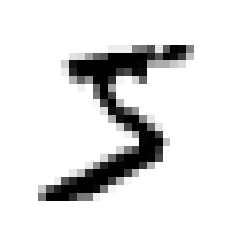

In [5]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y=y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test=X[:60000], X[60000:], y[:60000], y[60000:]
# slicing 주의, 뒷 숫자 포함 ㄴㄴ

#### 3-2) 이진 분류기 훈련

In [9]:
# 이진 분류기란, yes or no! 
# 5 이진 분류기=5인 것/5가 아닌 것
y_train_5= (y_train==5)
y_test_5= (y_test==5)
y_train_5[:2]

array([ True, False])

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

#### 3-3) 성능 측정

* 회귀 모델보다 분류 모델이 훨씬 성능 측정 지표가 많음!

In [12]:
# 1. 교차 검증

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# Q. 돌렸을 때 왜 교재와 다른 정확도가 나오는 것? 아래의 더미 분류기는 똑같이 출력됨. Hmm

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# class 함수 익숙하게 작성할 수 있도록 연습할 것★

In [14]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [15]:
# 2. 오차 행렬(confusion matrix)

from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# 첫째 행이 '5가 아님' 이라는 음성 클래스라는 것을 주의해야!

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [18]:
# 3. 정밀도와 재현율

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

# 위 오차행렬에서 정밀도를 3530/(3530+687)로 계산한 것과 같음.

0.8370879772350012

In [19]:
3530/(3530+687)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
3530/(3530+1891)

0.6511713705958311

정밀도와 재현율의 의미 $\longrightarrow\$ `분류의 정확도가 83.7%, 전체 5들 중에서 65.1%만 잡아냈다.`

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
# 4. 정밀도-재현율 트레이드오프(두 마리 토끼를 잡을 수 없다.)

y_scores=sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred=sgd_clf.predict([some_digit])
y_some_digit_pred

# 임곗값이 지금 0이고, some_digit의 점수는 2164점이니 당연히 true라고 함!

[2164.22030239]


array([ True])

In [24]:
threshold=8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44247 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\samsung\.conda\envs\test2\lib\site-packages\matplotlib\backends\ba

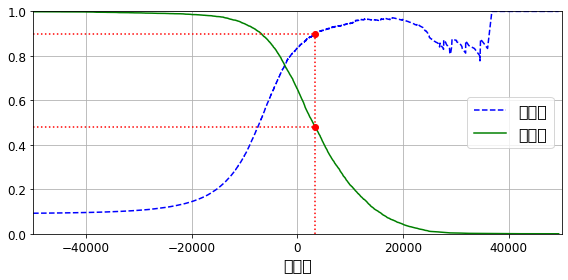

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label="재현율")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("임곗값", fontsize=16)        # Not shown in the book
    plt.grid(True)                              # Not shown in the book
    plt.axis([-50000, 50000, 0, 1])             # Not shown in the book


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()


# 그래프 그리는 코드 다시 공부

* 글꼴에 대한 오류 해결 방법

In [28]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 해당 코드를 추가하면 가능!

그림 저장: precision_vs_recall_plot


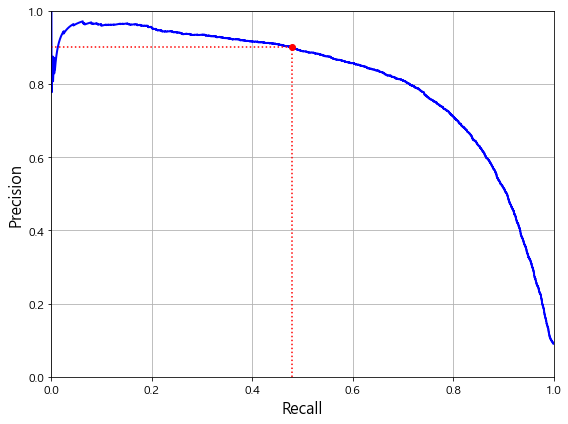

In [29]:
# 재현율 대비 정밀도 곡선

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [30]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]
threshold_90_precision

# 정밀도가 0.9가 되게 하는 가장 작은 임곗값 출력

3370.0194991439594

In [31]:
y_train_pred_90=(y_scores>=threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

# 정밀도는 90%를 달성했으나, 재현율이 너무 낮음. ㅠ

0.9000345901072293
0.4799852425751706


In [32]:
# 5. ROC 곡선

from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


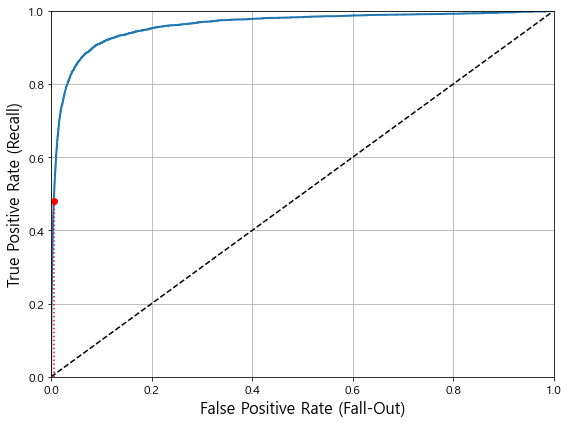

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
# 랜덤포레스트분류기 훈련시키고 비교하기

from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [36]:
y_scores_forest=y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

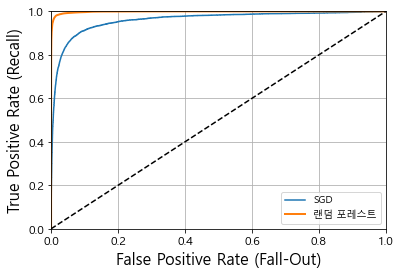

In [37]:
plt.plot(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#### 3-5) 다중 분류

In [42]:
from sklearn.svm import SVC

svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
np.argmax(some_digit_scores)
print(svm_clf.classes_)
svm_clf.classes_[5]

# 해당 예제의 경우에는 0부터 9까지의 숫자를 분류하는 것이기 때문에 classes의 인덱스와 정확히 숫자 이미지가 일치.
# 그래서 그냥 5번째가 제일 점수가 크면 5 그림이라고 알 수 있으나, 이런 경우는 굉장히 드묾.

[0 1 2 3 4 5 6 7 8 9]


5

In [ ]:
# OvO, OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
ovr_clf.estimators_

In [ ]:
# sgdClassifier (자동으로 다중 분류 해줌.)

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# 정밀도를 올려보기 위한 scaling 작업(여기에서는 표준화)

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

#### 3-5) 에러 분석

In [ ]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_trian, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#### 3-6) 다중 레이블 분류

* 여러 개의 이진 꼬리표를 출력하는 분류 시스템 $=$ 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train % 2 ==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KneighborClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

#### 3-7) 다중 출력 분류

In [ ]:
noise=np.random.randint(0, 100, (len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100, (len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [ ]:
some_index=0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)